# In class exercises for ML tutorials

## Read in data from eeg study
* This time I've kept in data across a 1s window from many electrodes (20) sampled at 250Hz, so now we have a [960, 20, 250] matrix that contains data from all 960 trials, 20 electrodes, and over a 1s window following stimulus onset
* Also read in a "cond_labels" vector that has 960 0's and 1's to mark trials from the two experimental conditions 

## import stuff...

In [41]:
import numpy as np
from scipy.linalg import eigh
from scipy.linalg import sqrtm
import scipy.stats as stats
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
import random

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

In [2]:
# load the data...
eeg = np.load('class_demo_eeg.npz')

# get the different arrays like this...
eeg['data']
eeg['sr']
eeg['tx']
eeg['cond_labels']

# shape of data
print('Shape of the big eeg data set: ', eeg['data'].shape)

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
cond_labels = eeg['cond_labels']

Shape of the big eeg data set:  (960, 20, 250)


## Compute the mean across the first dimension (trials) and then plot the mean response across time in each of the 20 electrodes on one axis

* Might need to transpose the data into a Time x Electrode format

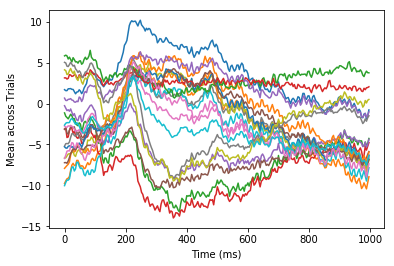

In [32]:
trial_mean = np.mean(data,axis=0).T
t = 1000*np.arange(250)/250

plt.plot(t,trial_mean)
plt.xlabel('Time (ms)')
plt.ylabel('Mean across Trials')
plt.show()

## That gives you an idea about what the pattern of data looks like across electrodes. 
* Next, take the mean across time, so you have a 960 x 20 matrix 
* Use the cond_labels vector to sort the data based on condition (so you have two 480 x 20 matrices)
* Do classification to see if you can decode the experimental condition
* Remember - break up your data into independent training and testing sets
* Set C to a small number if this is taking a long time...

In [4]:
time_mean = np.mean(data,axis=2)
data_cond0 = time_mean[cond_labels==0,:] #[480,20]
data_cond1 = time_mean[cond_labels==1,:] #[480,20]

In [5]:
row,col = data_cond0.shape
set_len = np.abs(np.array([0,row]) - int(np.round(.9*row,0)))

print('The size of training set is ',set_len[0],'; The size of the test set is ',set_len[1])

The size of training set is  432 ; The size of the test set is  48


## Classification using euclidean distance from mean

In [13]:
train = np.vstack((data_cond0[0:set_len[0],:],data_cond1[0:set_len[0],:]))
test = np.vstack((data_cond0[set_len[0]:,:],data_cond1[set_len[0]:,:]))
train_labels = np.hstack((np.zeros(set_len[0]),np.ones(set_len[0])))
test_labels = np.hstack((np.zeros(set_len[1]),np.ones(set_len[1])))

train_mean0 = np.mean(train[train_labels==0,:],axis=0)
train_mean1 = np.mean(train[train_labels==1,:],axis=0)

class_labels = np.zeros(test.shape[0])
for i in np.arange(test.shape[0]):
    # compute euclidean distance to the mean for each condition
    distance0 = np.sqrt(np.sum(np.power((test[i,:]-train_mean0),2)))
    distance1 = np.sqrt(np.sum(np.power((test[i,:]-train_mean1),2)))
    class_labels[i] = np.argmin([distance0,distance1])

class_acc = np.sum(class_labels==test_labels)/test.shape[0]
print('Euclidean distance classification accuracy is: ', class_acc)

Euclidean distance classification accuracy is:  0.677083333333


## Classification using normalized euclidean distance from mean

In [14]:
# compute pooled pooled variance (variance of each condition weighted by number of data points in each condition)
numer = ((set_len[0]-1)*np.var(train[train_labels==0,:],axis=0) +
    (set_len[0]-1)*np.var(train[train_labels==1,:],axis=0))
denom = 2*(set_len[0]-1)
pooled_variance = numer/denom

class_labels2 = np.zeros(test.shape[0])

for i in np.arange(test.shape[0]):
    # compute normalized euclidean distance to the mean for each condition
    distance0 = np.sqrt(np.sum(np.power((test[i,:]-train_mean0)/pooled_variance,2)))
    distance1 = np.sqrt(np.sum(np.power((test[i,:]-train_mean1)/pooled_variance,2)))
    class_labels2[i] = np.argmin([distance0,distance1])

class_acc = np.sum(class_labels2==test_labels)/test.shape[0]
print('Normalized Euclidean distance classification accuracy is: ', class_acc)

Normalized Euclidean distance classification accuracy is:  0.6875


## Classification using Mahalonobis distance

In [20]:
# computer pooled covariance
numer = ((set_len[0]-1)*np.cov(train[train_labels==0,:],rowvar=0) +
    (set_len[0]-1)*np.cov(train[train_labels==1,:],rowvar=0))
denom = 2*(set_len[0]-1)
pooled_covariance = numer/denom

class_labels3 = np.zeros(test.shape[0])

for i in np.arange(test.shape[0]):
    # compute maholonobis distance to the mean for each condition
    distance0 = np.sqrt((test[i,:]-train_mean0) @ np.linalg.inv(pooled_covariance) @ (test[i,:]-train_mean0).T)
    distance1 = np.sqrt((test[i,:]-train_mean1) @ np.linalg.inv(pooled_covariance) @ (test[i,:]-train_mean1).T)
    class_labels3[i] = np.argmin([distance0,distance1])

class_acc = np.sum(class_labels3==test_labels)/test.shape[0]
print('Mahalonobis distance classification accuracy is: ', class_acc)
print(class_labels3)

Mahalonobis distance classification accuracy is:  0.552083333333
[ 1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.
  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.
  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.
  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.
  0.  1.  1.  0.  0.  0.]


## Support Vector Machines (SVMs)

In [21]:
model = SVC(kernel='linear', C=1) # if C = big, hard margin; if C = small, some leakage
model.fit(train,train_labels)
class_labels4 = model.predict(test)

# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels4==test_labels) /  test.shape[0]
print('Classification accuracy with a SVM is: ', class_acc)

Classification accuracy with a SVM is:  0.552083333333


## Now try doing this across timepoints!
* First do a time window based on where you think there is nice separation in the responses across electrodes (look at the data that you plotted above)...maybe try 300-400msec post stim
* Then you can try timepoint x timepoint or a moving window

In [61]:
t_window = (t>=300)&(t<400)
data_window = np.mean(data[:,:,t_window],axis=2)

data_cond0 = data_window[cond_labels==0,:] #[480,20]
data_cond1 = data_window[cond_labels==1,:] #[480,20]

train = np.vstack((data_cond0[0:set_len[0],:],data_cond1[0:set_len[0],:]))
test = np.vstack((data_cond0[set_len[0]:,:],data_cond1[set_len[0]:,:]))
train_labels = np.hstack((np.zeros(set_len[0]),np.ones(set_len[0])))
test_labels = np.hstack((np.zeros(set_len[1]),np.ones(set_len[1])))

train_mean0 = np.mean(train[train_labels==0,:],axis=0)
train_mean1 = np.mean(train[train_labels==1,:],axis=0)

In [39]:
model = SVC(kernel='linear', C=1) # if C = big, hard margin; if C = small, some leakage
model.fit(train,train_labels)
class_labels5 = model.predict(test)

# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels5==test_labels) /  test.shape[0]
print('Classification accuracy for 300-400ms with a SVM is: ', class_acc)

Classification accuracy for 300-400ms with a SVM is:  0.677083333333


## Bonus - try using randomization testing to eval significance

In [74]:
rand_class_labels = np.zeros((10,96))
class_accuracy = np.zeros(10)

for i in np.arange(10): 
    rand_train_labels = np.random.permutation(train_labels)
    train_mean0 = np.mean(train[rand_train_labels==0,:],axis=0)
    train_mean1 = np.mean(train[rand_train_labels==1,:],axis=0)
    model = SVC(kernel='linear', C=1) # if C = big, hard margin; if C = small, some leakage
    model.fit(train,rand_train_labels)
    #print(np.shape(model.predict(test)))
    rand_class_labels[i,:] = model.predict(test).T
    class_accuracy[i] = np.sum(rand_class_labels[i,:]==test_labels)/test.shape[0]

In [75]:
print(class_accuracy)

[ 0.61458333  0.42708333  0.53125     0.51041667  0.52083333  0.39583333
  0.5625      0.47916667  0.58333333  0.46875   ]
